# Raman spectrum baseline subtraction and peak fitting

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from scipy.signal import find_peaks

%matplotlib tk

In [75]:
data_file_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Raman\23.06.21 MWCNTs\MWCNTs_patterned.txt"
df = pd.read_csv(data_file_path, sep=r"\s+", skiprows=1, header=None)
data = np.genfromtxt(data_file_path, delimiter="\t", skip_header=1)
wave_numbers = data[:, 0]
intensities = data[:, 1]

In [76]:
plt.plot(wave_numbers, intensities)

In [88]:
# print number of elements in the find_peaks tuble
peak_indices = find_peaks(intensities, prominence= 500)[0]
print(peak_indices[0], peak_indices[1])
plt.plot(wave_numbers, intensities)
plt.scatter(wave_numbers[peak_indices], intensities[peak_indices], c='r')
plt.show()
print(intensities[peak_indices[0]],intensities[peak_indices[1]])

print('I_D/I_G = ', intensities[peak_indices[1]]/intensities[peak_indices[0]])


234 380
6162.945313 1059.322876
I_D/I_G =  0.17188581468757874


In [80]:
baseline_values = peakutils.baseline(intensities, 2)
plt.plot(df[0], df[1])
plt.plot(wave_numbers, baseline_values, color="red")
plt.show()

In [14]:
import glob

my_files_path = glob.glob(r'C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Raman\23.06.21 MWCNTs\*.txt')
print(my_files_path)

['C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_patterned.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_patterned1.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_patterned2.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_patterned_map_bottom.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_patterned_map_Copy.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_unpatterned.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_unpatterned1.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Data\\Midi\\Raman\\23.06.21 MWCNTs\\MWCNTs_unpatterned2.txt', 'C:\\Users\\lb958\\OneDrive - University of Cambridge\\Da

In [18]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [19]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

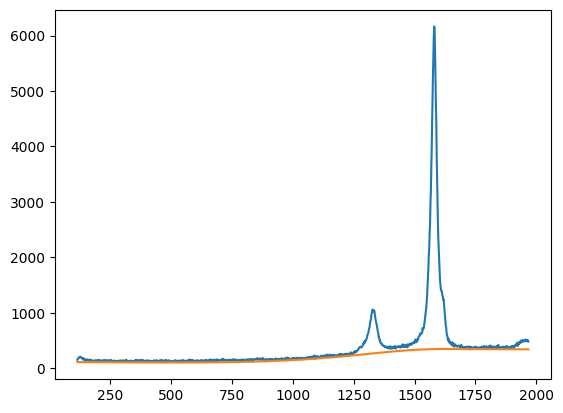

In [27]:
baseline = baseline_als(intensities, 100000, 0.0001, 1000)
plt.plot(wave_numbers, intensities)
plt.plot(wave_numbers, baseline)

In [93]:
from pybaselines import Baseline, utils

def generate_baseline(x_data, y_data):
    baseline_fitter = Baseline(x_data = x_data)
    baseline = baseline_fitter.mor(y_data, half_window=30)[0]
    return baseline



### Analysis from file to baseline subtraction + I_D/I_G

In [214]:
def process_raman_data(wave_numbers,intensities, fig, ax):
    # generate baseline
    baseline = generate_baseline(wave_numbers, intensities)
    corrected_intensities = intensities - baseline
    corrected_intensities = corrected_intensities/np.max(corrected_intensities)
    #plot raw data, baseline and corrected data
    ax.set_title('Raman spectrum')
    ax.set_xlabel('Wave number (cm$^{-1}$)')
    ax.set_ylabel('Intensity (a.u.)')
    
    ax.plot(wave_numbers, corrected_intensities)
    
    #remove numbers on y axis
    ax.set_yticklabels([])

    # find and plot peaks
    peak_indices = find_peaks(corrected_intensities, prominence= 0.05, distance=20, width=10)[0]
    #discard peak indices in first quarter of spectrum
    peak_indices = peak_indices[peak_indices < len(wave_numbers)/2]

    ax.scatter(wave_numbers[peak_indices], corrected_intensities[peak_indices], c='r')
    # mark peak positions on plot
    peaks_string = ""
    for i in peak_indices:
        peaks_string = peaks_string + "Peak at {:.2f} cm$^{{-1}}$, intensity {:.2f} \n".format(wave_numbers[i], corrected_intensities[i])
    # place box with peaks_string
    ax.text(0.05, 0.5, peaks_string, 
            transform=ax.transAxes, fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # place box with I_D/I_G value
    ax.text(0.05, 0.95, 'I_D/I_G = {:.4f}'.format(corrected_intensities[peak_indices[1]]/corrected_intensities[peak_indices[0]]), 
            transform=ax.transAxes, fontsize=14, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))    

In [215]:
def process_raman(data_file_path,figure_generated = False):
    if figure_generated == False:
        fig, ax = plt.subplots()
    # generate data from file
    data = np.genfromtxt(data_file_path, delimiter="\t", skip_header=1)
    wave_numbers = data[:, 0]
    intensities = data[:, 1]

    process_raman_data(wave_numbers,intensities, fig, ax)
    fig.show()



In [216]:
process_raman(data_file_path)

In [217]:
map_data_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Raman\23.06.21 MWCNTs\MWCNTs_patterned_map_bottom.txt"
# Read the data from the file
data = pd.read_csv(map_data_path, sep=r'\s+')
data.head()


,#X,#Y,#Wave,#Intensity
0,-120.0,-80.0,1879.449219,1078.561768
1,-120.0,-80.0,1877.822266,1026.323730
2,-120.0,-80.0,1876.194336,1092.124634
3,-120.0,-80.0,1874.566406,1101.073730
4,-120.0,-80.0,1872.938477,1116.159546


In [218]:
# Extract x, y coordinates, wavelength, and intensity
x_coordinates = data['#X']
y_coordinates = data['#Y']
wavelengths = data['#Wave']
intensities = data['#Intensity']

# Create a grid plot
fig, ax = plt.subplots()

# Plot the grid points
ax.scatter(x_coordinates, y_coordinates)

# Function to handle mouse click events
def on_click(event):
    if event.inaxes is not None:
        # Retrieve the clicked point coordinates
        x = 5*(round(event.xdata/5))
        y = 5*(round(event.ydata/5))
        
        # Filter the data for the clicked point
        mask = (x_coordinates == x) & (y_coordinates == y)
        point_wavelengths = np.array(wavelengths[mask])
        point_intensities = np.array(intensities[mask])
        
        # Create a new figure for the spectrum plot
        fig_spectrum, ax_spectrum = plt.subplots()
        
        # Plot the spectrum
        process_raman_data(point_wavelengths, point_intensities, fig_spectrum, ax_spectrum)
        
        # Show the spectrum plot
        plt.show()


# Connect the click event to the function
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


Traceback (most recent call last):
  File "c:\Users\lb958\Code\midi\.venv\Lib\site-packages\matplotlib\cbook\__init__.py", line 304, in process
    func(*args, **kwargs)
  File "C:\Users\lb958\AppData\Local\Temp\ipykernel_25800\62815823.py", line 29, in on_click
    process_raman_data(point_wavelengths, point_intensities, fig_spectrum, ax_spectrum)
  File "C:\Users\lb958\AppData\Local\Temp\ipykernel_25800\1934747220.py", line 31, in process_raman_data
    ax.text(0.05, 0.95, 'I_D/I_G = {:.4f}'.format(corrected_intensities[peak_indices[1]]/corrected_intensities[peak_indices[0]]),
                                                                       ~~~~~~~~~~~~^^^
IndexError: index 1 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "c:\Users\lb958\Code\midi\.venv\Lib\site-packages\matplotlib\cbook\__init__.py", line 304, in process
    func(*args, **kwargs)
  File "C:\Users\lb958\AppData\Local\Temp\ipykernel_25800\62815823.py", line 29, in on_click
    